<h1> Mining CoCoRaHS Data to find a heavy rain</h1>

In [1]:
import pandas
from IPython.display import Image
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib 
import pyart
import numpy as np
%matplotlib inline


First lets look at the CoCoRaHS stations around Portland Maine

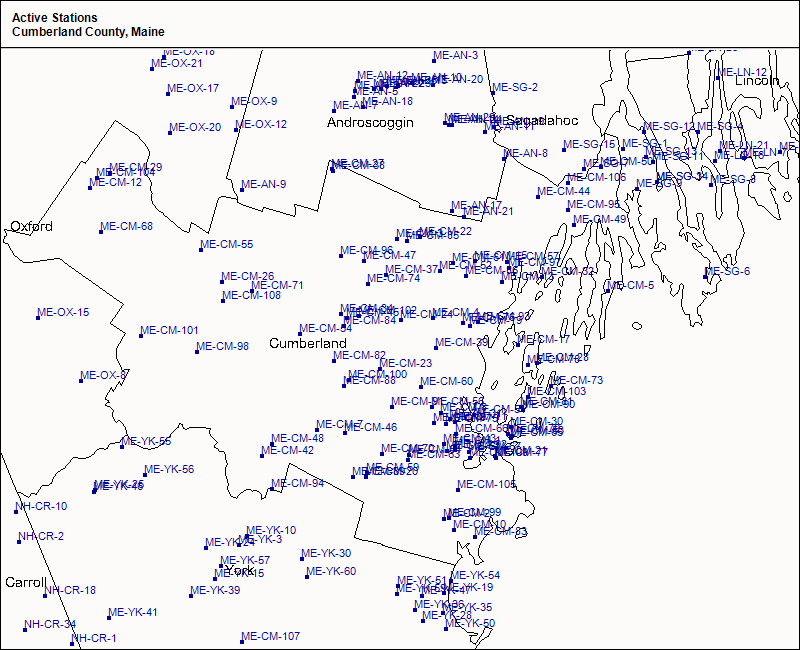

In [2]:
Image(filename='./Cumberland.png') 

Lets read in the CSV data from the 1st of Febuary to today, June the 17th

In [3]:
df = pandas.read_csv('../data/DailyPrecipReports_ME_2015-02-01_1.csv')


In [4]:
print(df.columns)
print(df['StationNumber'])

Index([u'ObservationDate', u'ObservationTime', u'EntryDateTime', u'StationNumber', u'StationName', u'Latitude', u'Longitude', u'TotalPrecipAmt', u'NewSnowDepth', u'NewSnowSWE', u'TotalSnowDepth', u'TotalSnowSWE', u'DateTimeStamp'], dtype='object')
0       ME-KX-1
1      ME-CM-98
2      ME-HN-21
3      ME-CM-81
4      ME-YK-52
5      ME-CM-93
6      ME-LN-21
7      ME-YK-31
8      ME-CM-37
9      ME-LN-12
10      ME-LN-8
11     ME-KB-17
12      ME-KX-5
13      ME-HN-4
14      ME-WS-8
...
8367     ME-SM-32
8368      ME-LN-1
8369      ME-SM-3
8370      ME-FR-4
8371      ME-KB-6
8372     ME-AN-28
8373      ME-HN-7
8374     ME-KB-10
8375     ME-CM-13
8376      ME-WS-4
8377      ME-SG-1
8378     ME-HN-28
8379     ME-PN-10
8380      ME-YK-3
8381     ME-YK-48
Name: StationNumber, Length: 8382, dtype: object


Lets use Pandas to subset out one station

In [5]:
df_sp = df.loc[df['StationNumber'] == ' ME-CM-105']

Add the time of observation to the date of observation and turn them into date times and the strings into floats

In [6]:
df_sp['datetime'] = df_sp.ObservationDate + df_sp.ObservationTime
new_sp = df_sp.convert_objects(convert_numeric=True, convert_dates = True)

/Users/scollis/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Plot it out! 

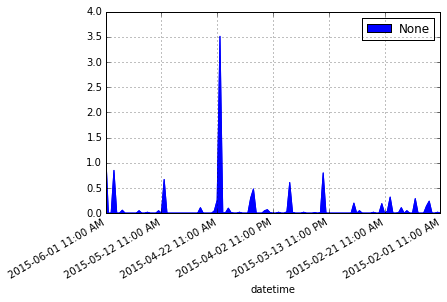

In [7]:
fig = plt.figure(figsize = [20,8])
s = new_sp.set_index('datetime')
s.plot(y = 'TotalPrecipAmt', kind = 'area')
ax = plt.gca()
cnt = plt.gcf()
cnt.autofmt_xdate()


Hmm.. Some big action around the 22nd of April Lets zoom in by subsetting on the big precip times..

In [8]:
big_rain = new_sp.loc[new_sp['TotalPrecipAmt'] > 1.0]
filtered = big_rain.drop(['Longitude', 
                          'Latitude',
                          'NewSnowDepth',
                         'StationName', 'DateTimeStamp',
                         'NewSnowSWE',
                         'TotalSnowSWE'], 1)#drop for brevity and privacy

In [9]:
filtered

,ObservationDate,ObservationTime,EntryDateTime,StationNumber,TotalPrecipAmt,TotalSnowDepth,datetime
26,2015-06-01,11:00 AM,2015-06-01 01:48 PM,ME-CM-105,1.25,NaN,2015-06-01 11:00 AM
3261,2015-04-21,11:00 AM,2015-04-21 03:27 PM,ME-CM-105,3.51,NaN,2015-04-21 11:00 AM


Boom! We can see on the 21st of april, at 7am Local time the observer (Citizen scientist) recored 3.51 in of rain in the previous 24 hours. Lets pull all records from that morning

In [10]:
all_big_rain = df.loc[df['ObservationDate'] == '2015-04-21']

In [11]:
all_big_rain['StationNumber'] +all_big_rain['TotalPrecipAmt']

3234      ME-KX-1 1.37
3235     ME-HN-21 2.15
3236     ME-YK-47 3.36
3237     ME-CM-98 1.83
3238     ME-YK-46 1.82
3239      ME-KX-5 1.59
3240     ME-YK-51 3.46
3241     ME-CM-91 2.63
3242      ME-LN-8 2.40
3243     ME-KB-17 2.24
3244     ME-CM-37 2.17
3245     ME-YK-31 2.16
3246     ME-LN-12 1.96
3247     ME-LN-21 1.84
3248     ME-WL-22 1.28
...
3305     ME-KB-10 1.83
3306     ME-AN-28 1.76
3307     ME-YK-57 1.89
3308     ME-CM-13 2.72
3309     ME-CM-20 2.31
3310      ME-SG-1 1.92
3311     ME-AN-16 1.73
3312      ME-FR-2 1.53
3313     ME-AN-25 1.30
3314     ME-HN-17 0.73
3315     ME-PN-26 0.50
3316      ME-YK-3 1.85
3317     ME-YK-48 1.79
3318      ME-WS-4 0.44
3319     ME-PN-10 0.05
Length: 86, dtype: object

I think we have found a target case!

In [34]:
radar = pyart.io.read('/data/maine/KGYX20150421_105832_V06.gz')
rain_z = radar.fields['reflectivity']['data'].copy()
z_lin = 10.0**(radar.fields['reflectivity']['data']/10.)
rain_z = (z_lin/300.0)**(1./1.4)  #Z=300 R1.4
radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)
radar.fields['rain_z']['units'] = 'mm/h'
radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
radar.fields['rain_z']['valid_min'] = 0
radar.fields['rain_z']['valid_max'] = 500
        

In [36]:
myd = pyart.graph.RadarMapDisplay(radar)


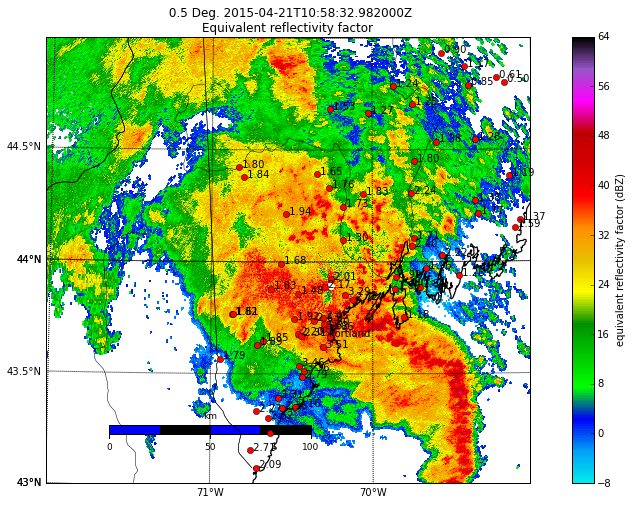

In [46]:
fig = plt.figure(figsize = [15,8])
myd.plot_ppi_map( 'reflectivity', vmin = -8, vmax = 64, 
                 resolution = 'h', max_lat = 45, 
                 min_lat = 43, min_lon = -72, max_lon = -69,
                cmap = pyart.graph.cm.NWSRef, mask_outside = False)
m = myd.basemap
m.drawparallels(np.linspace(43, 45, 5),labels=[1,0,0,0])
m.drawmeridians(np.linspace(-72, -69, 4),labels=[0,0,0,1])
m.drawrivers()
m.drawmapscale(-71, 43.25, -71, 43.25, 100, barstyle='fancy', 
               fontcolor='k', fillcolor1='b', fillcolor2='k')
myd.plot_point( -70.2667,43.6667, label_text = 'Portland', 
               label_offset = (0.0,0.0) )
for i in all_big_rain.iterrows():
    if i[1]['Latitude'] < 45 and i[1]['Latitude'] > 43 \
    and i[1]['Longitude'] > -72 and i[1]['Longitude'] < -69:
        myd.plot_point( i[1]['Longitude'], i[1]['Latitude'], 
                       label_text = i[1]['TotalPrecipAmt'], 
                   label_offset = (0.0,0.0) )


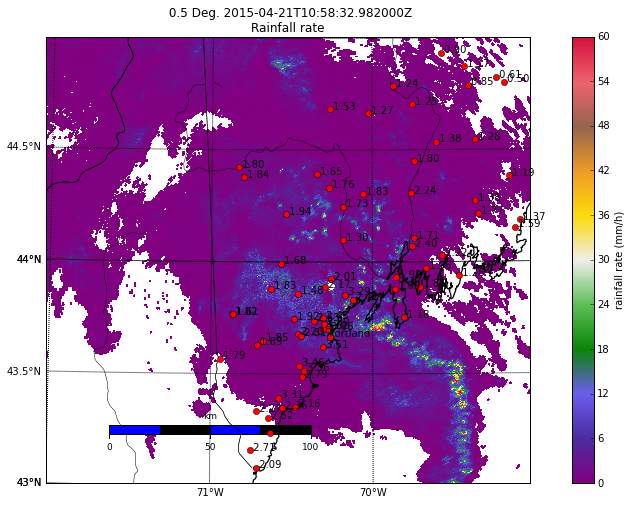

In [47]:
fig = plt.figure(figsize = [15,8])
myd.plot_ppi_map( 'rain_z', vmin = 0, vmax = 60, 
                 resolution = 'h', max_lat = 45, 
                 min_lat = 43, min_lon = -72, max_lon = -69,
                cmap = pyart.graph.cm.RRate11, mask_outside = False)
m = myd.basemap
m.drawparallels(np.linspace(43, 45, 5),labels=[1,0,0,0])
m.drawmeridians(np.linspace(-72, -69, 4),labels=[0,0,0,1])
m.drawrivers()
m.drawmapscale(-71, 43.25, -71, 43.25, 100, barstyle='fancy', 
               fontcolor='k', fillcolor1='b', fillcolor2='k')
myd.plot_point( -70.2667,43.6667, label_text = 'Portland', 
               label_offset = (0.0,0.0) )
for i in all_big_rain.iterrows():
    if i[1]['Latitude'] < 45 and i[1]['Latitude'] > 43 \
    and i[1]['Longitude'] > -72 and i[1]['Longitude'] < -69:
        myd.plot_point( i[1]['Longitude'], i[1]['Latitude'], 
                       label_text = i[1]['TotalPrecipAmt'], 
                   label_offset = (0.0,0.0) )
